In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "50g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/12/15 13:02:30 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/12/15 13:02:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/15 13:02:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# base_path = "/data/saturation/thesis_run_20240929/"
base_path = "/data/saturation/thesis_run_20241203/"

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pd = configs_df.toPandas()

configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for k, v in read_config(Path(config_file))["run_configurations"].items():
        configs_dict[k] = v

In [5]:
configs_pd[configs_pd.slope.between(-5.1, -4.9)].sort_values("slope")

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
17,0.75,"{'name': None, 'ratio': 7.0}",1.9,62,-5.0,250,2000
25,0.75,"{'name': None, 'ratio': 7.0}",1.1,60,-5.0,250,2000
42,0.50,"{'name': None, 'exponent': 0.30000000000000004}",1.5,173,-5.0,250,2000
43,0.50,"{'name': None, 'exponent': 0.55}",1.5,238,-5.0,250,2000
57,0.50,"{'name': None, 'exponent': 0.2}",1.5,147,-5.0,250,2000
95,0.25,"{'name': None, 'ratio': 7.0}",1.9,61,-5.0,250,2000
99,0.50,"{'name': None, 'exponent': 0.25}",1.5,160,-5.0,250,2000
109,0.50,"{'name': None, 'exponent': 0.9}",1.5,329,-5.0,250,2000
110,0.50,"{'name': None, 'exponent': 0.4}",1.5,199,-5.0,250,2000
126,0.50,"{'name': None, 'exponent': 0.7000000000000001}",1.5,277,-5.0,250,2000


## Example CSFD

In [18]:
slope = -5
simulation_id = 2
young_target_ntot = 5e2
older_target_ntot = 1e4
oldest_target_ntot = int(1e6)

study_region_size = configs_dict[simulation_id]["study_region_size"]
r_stat = configs_dict[simulation_id]["r_stat"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = simulation_id
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

young_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    young_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)

older_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    older_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)

oldest_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    oldest_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)   

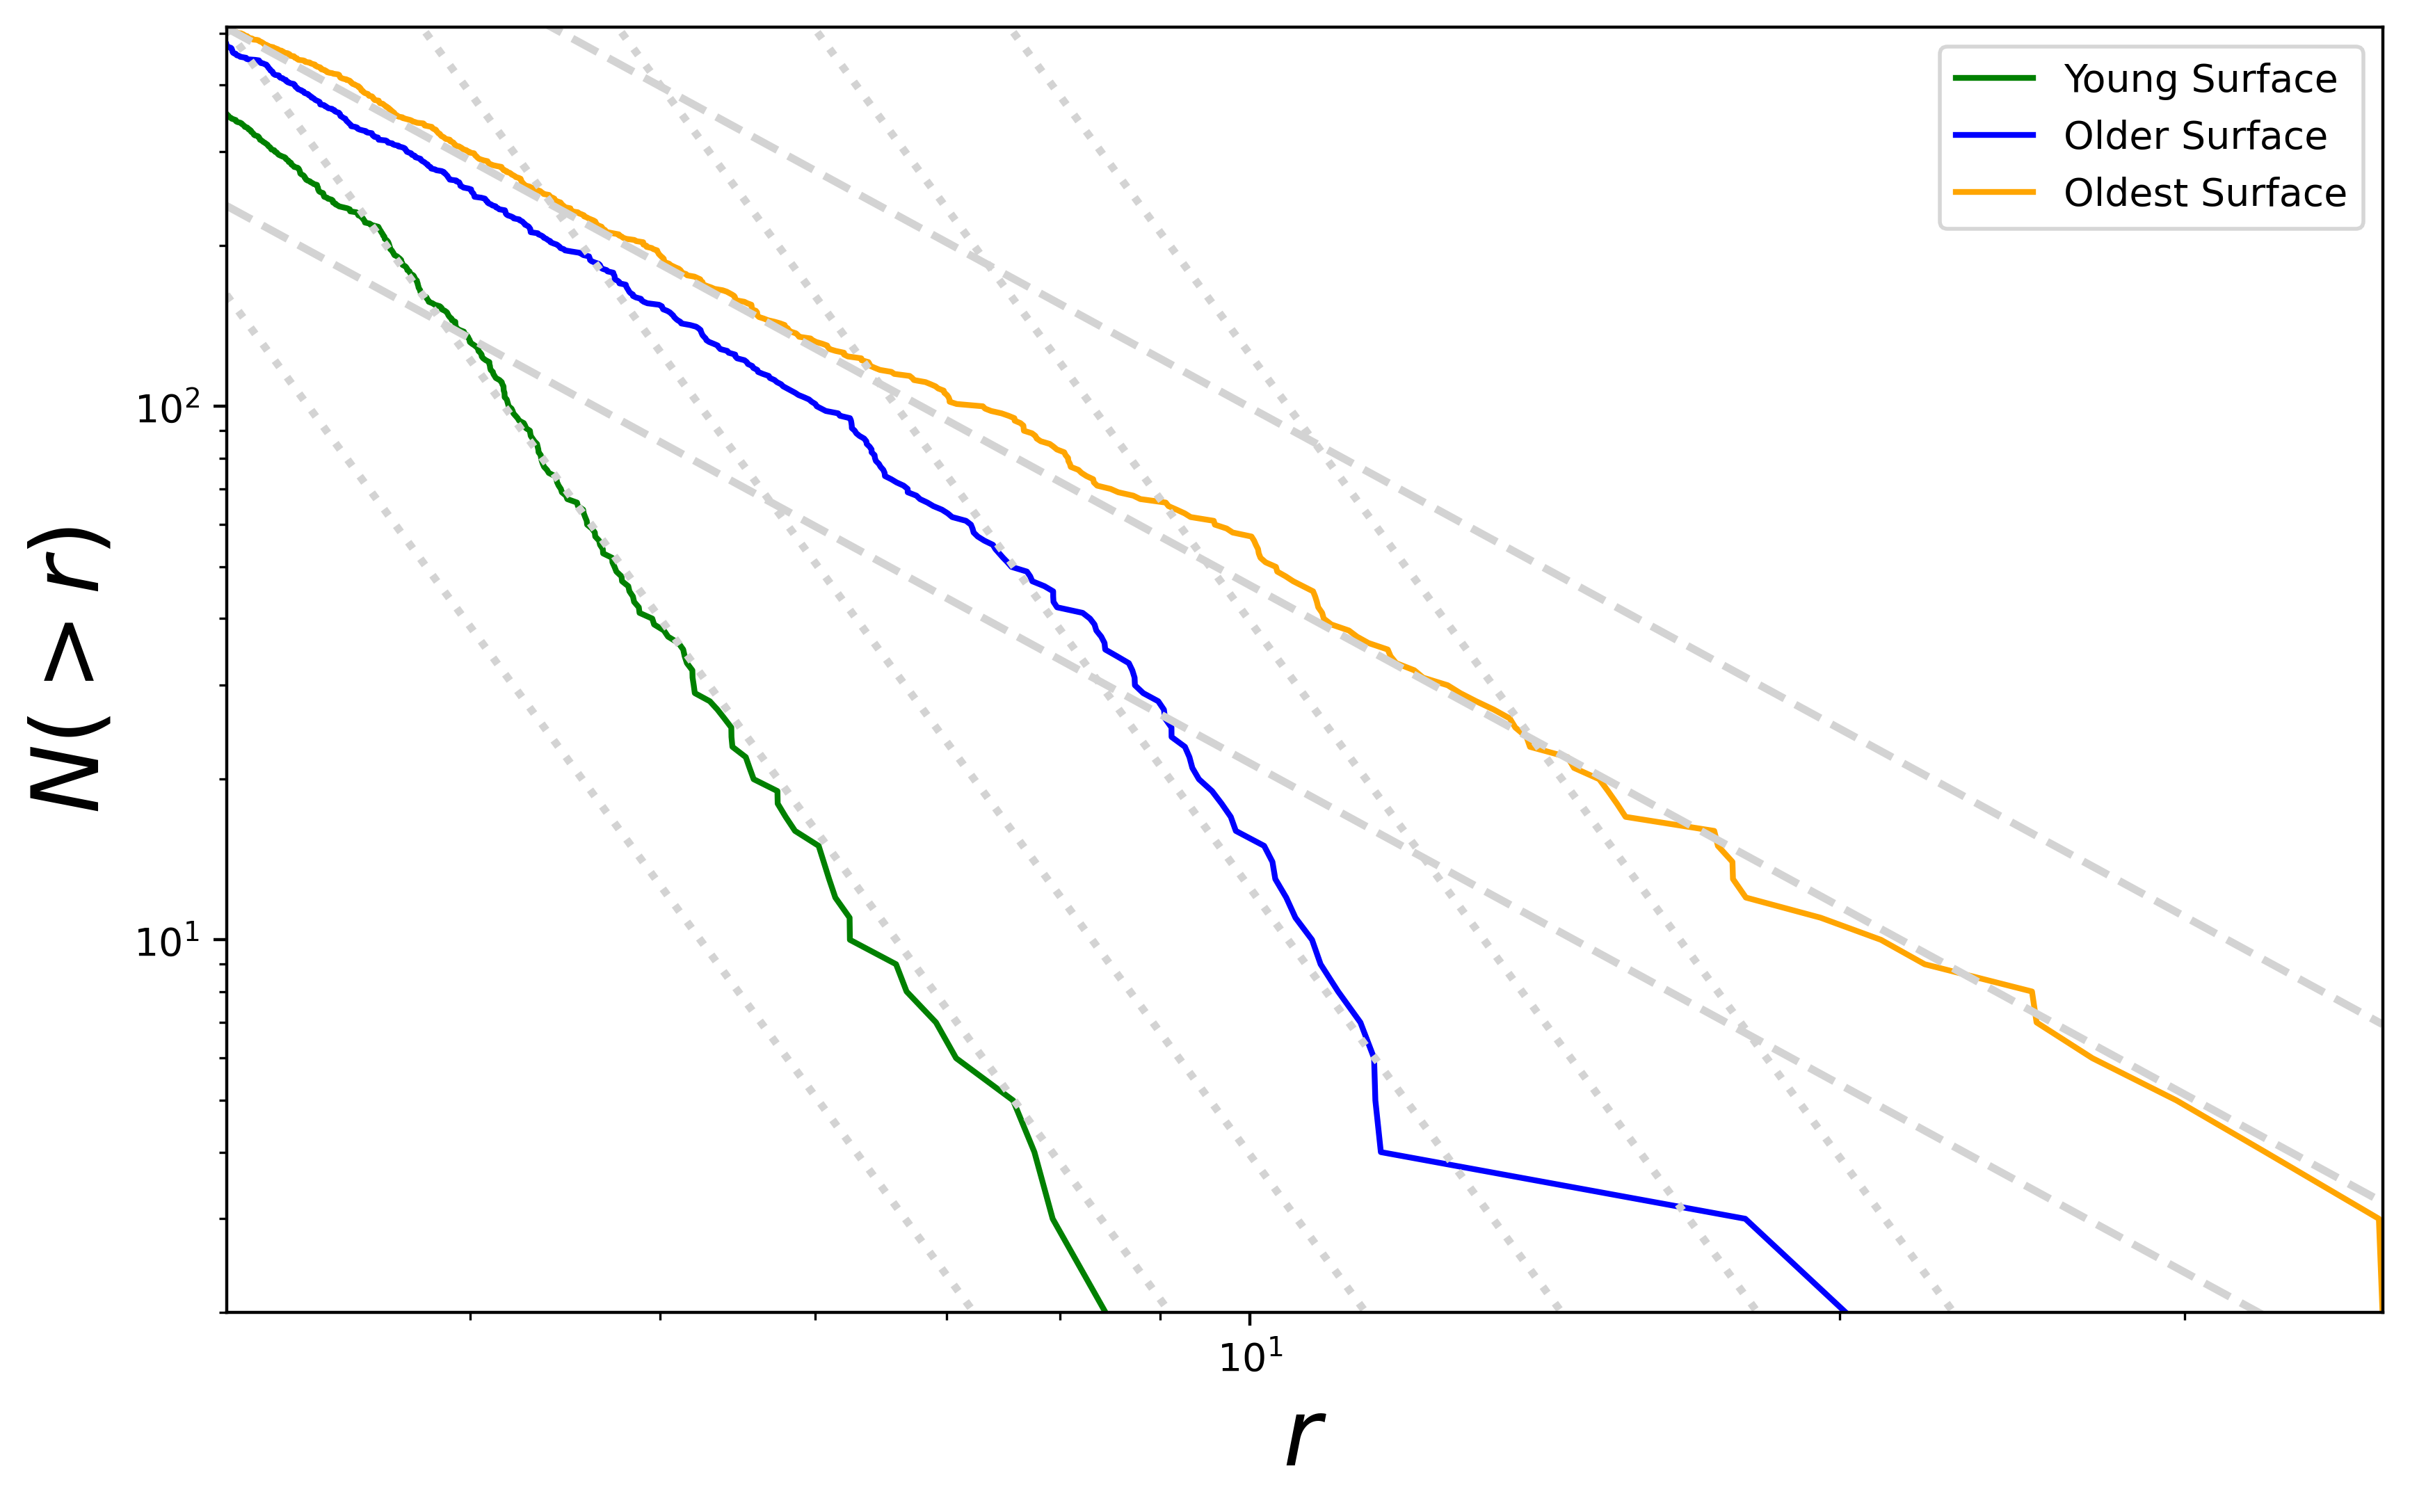

In [30]:
font_size = 24
saturation_ref_lines_indexes = range(-1, 2)
production_ref_lines = range(-1, 5)

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
nobs_old = oldest_radii.count()
min_r_old = oldest_radii.min()

fig = plt.figure(figsize=(10, 6), dpi=400)
ax = fig.add_subplot(111)

# Plot young state
observed_young_y = range(len(young_radii) + 1, 1, -1)
ax.plot(young_radii, observed_young_y, label="Young Surface", color="green")

# Plot older state
observed_older_y = range(len(older_radii) + 1, 1, -1)
ax.plot(older_radii, observed_older_y, label="Older Surface", color="blue")

# Plot old state
observed_oldest_y = range(len(oldest_radii) + 1, 1, -1)
ax.plot(oldest_radii, observed_oldest_y, label="Oldest Surface", color="orange")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(oldest_radii.min()), np.log10(oldest_radii.max()), 100)

saturation_ref_intercept = nobs_old / min_r_old ** -2
production_ref_intercept = nobs_old / min_r_old ** slope

# Slopes and intercepts
reference_lines = {
    -2: {
        "intercepts": [10**(x / 3) * saturation_ref_intercept for x in saturation_ref_lines_indexes],
        "style": "dashed"
    },
    -5: {
        "intercepts": [10**(x / 2) * production_ref_intercept for x in production_ref_lines],
        "style": "dotted"
    }
}

for slope, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**slope
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(oldest_radii.min(), oldest_radii.max())
ax.set_ylim(min(observed_oldest_y), max(observed_oldest_y))

# Labels and scaling
ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N(> r)$", fontsize=font_size)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/example_csfds.png", bbox_inches="tight")

plt.show()